# Week 2 - Seminar - Exploratory Data Analysis and Plotting


In [ ]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# This prevents pandas from showing weird warnings
pd.options.mode.chained_assignment = None

## Agenda

- Any questions about the homework task?
- Any questions from the weeks material (textbook chapters and the video)?

Repeat 10 times:
1. I show you the task
2. You work on it for 3-5 minutes
3. I show you my solution
4. You compare my solution to yours and raise questions, we discuss for several minutes.

Use the notebook that I shared on Teams.


## Data Preprocessing From Last Week

Copy data preprocessing from the lecture notebook. If you're using Google Colab, keep in mind that your data might be saved in the `MyDrive/attendance` folder - adjust the query below accordingly. 

In [35]:
df = duckdb.sql(
    """
        WITH attendance AS (
            SELECT
                report_period,
                school_code,
                student_class,
                subject_code,
                electronic_diary,
                FIRST(student_count_diary) student_count_diary,
                SUM(excused_lessons_illness) excused_lessons_illness,
                SUM(excused_lessons_other) excused_lessons_other,
                SUM(unexcused_lessons) unexcused_lessons
            FROM 'attendance/attendance.parquet'
            WHERE division_code IS NULL
            GROUP BY all
        ),
            school AS (
            SELECT 
                school_code, 
                school_name, 
                municipality_name
            FROM 'attendance/school.parquet' 
            WHERE division_code IS NULL
        ),
            subject AS (
            SELECT
                electronic_diary,
                subject_code,
                subject_name_en,
            FROM 'attendance/subject.parquet'
        )
        SELECT
            school.school_name,
            school.school_code,
            school.municipality_name,
            attendance.student_class,
            attendance.report_period,
            subject.subject_name_en,
            FIRST(attendance.student_count_diary) AS student_count,
            SUM(attendance.excused_lessons_illness) AS excused_lessons_illness,
            SUM(attendance.excused_lessons_other) AS excused_lessons_other,
            SUM(attendance.unexcused_lessons) AS unexcused_lessons
        FROM attendance
        JOIN school ON attendance.school_code = school.school_code
        JOIN subject ON attendance.subject_code = subject.subject_code
            AND attendance.electronic_diary = subject.electronic_diary
        GROUP BY all
"""
).df()

In [36]:
df = df[(df["subject_name_en"] == "Mathematics") & (df["student_class"] == 12)]

In [37]:
# Filter on report period
df = df[df["report_period"].between("2018-09-01", "2024-05-31")]
# Get rid of summer months
df["month"] = df["report_period"].dt.month
df = df[~df["month"].isin([6, 7, 8])]

# Make sure the set of schools is the same across the years
# First, count how many report periods each school has
schools = df.groupby("school_name").agg(
    report_period_count=("report_period", "nunique")
)
# Then, filter on the schools that have data for all 6 school years (9 months each year)
schools = schools[schools["report_period_count"] == 6 * 9]
df = df[df["school_name"].isin(schools.index)]

df["school_year"] = df["report_period"].dt.year - (
    df["report_period"].dt.month <= 5
).astype(int)
df[["report_period", "school_year"]].sample(5)

df["excused_illness_per_student"] = df["excused_lessons_illness"] / df["student_count"]
df["excused_other_per_student"] = df["excused_lessons_other"] / df["student_count"]
df["unexcused_per_student"] = df["unexcused_lessons"] / df["student_count"]
df["total_missed"] = (
    df["excused_lessons_illness"]
    + df["excused_lessons_other"]
    + df["unexcused_lessons"]
)
df["total_missed_per_student"] = df["total_missed"] / df["student_count"]

df.sample(5)

,school_name,school_code,municipality_name,student_class,report_period,subject_name_en,student_count,excused_lessons_illness,excused_lessons_other,unexcused_lessons,month,school_year,excused_illness_per_student,excused_other_per_student,unexcused_per_student,total_missed,total_missed_per_student
2340245,Elektrėnų sav. Vievio gimnazija,190669038,Elektrėnų sav.,12,2022-04-01,Mathematics,39,47.0,2.0,54.0,4,2021,1.205128,0.051282,1.384615,103.0,2.641026
3230510,Vilniaus Tuskulėnų gimnazija,190002030,Vilniaus m. sav.,12,2022-10-01,Mathematics,48,108.0,19.0,13.0,10,2022,2.250000,0.395833,0.270833,140.0,2.916667
1703378,Vilniaus „Juventos“ gimnazija,190008599,Vilniaus m. sav.,12,2023-09-01,Mathematics,131,487.0,114.0,0.0,9,2023,3.717557,0.870229,0.000000,601.0,4.587786
198193,Jurbarko Antano Giedraičio-Giedriaus gimnazija,290917890,Jurbarko r. sav.,12,2024-04-01,Mathematics,109,84.0,79.0,75.0,4,2023,0.770642,0.724771,0.688073,238.0,2.183486
1789023,Lazdijų r. Veisiejų Sigito Gedos gimnazija,290608520,Lazdijų r. sav.,12,2019-12-01,Mathematics,27,27.0,13.0,0.0,12,2019,1.000000,0.481481,0.000000,40.0,1.481481


In [25]:
df["report_period"] = df["report_period"].dt.date

## Tasks

### Task 1

Show how average `total_missed_per_student` changes across time. The plot should be titled, and axes should be labelled clearly. 


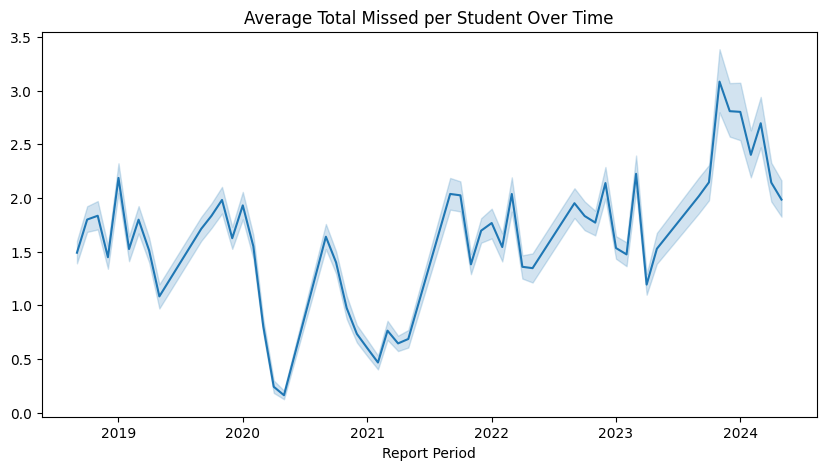

In [39]:
# Answer
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="report_period", y="total_missed_per_student")
plt.title("Average Total Missed per Student Over Time")
plt.xlabel("Report Period")
plt.ylabel(None);

### Task 2

Show how average `total_missed_per_student` changes across time for these municipalities:

* Vilniaus m. sav.
* Vilniaus r. sav.
* Kauno m. sav.
* Kauno r. sav.

The lines should have no errorbar. 


In [27]:
municipalities = [
    "Vilniaus m. sav.",
    "Vilniaus r. sav.",
    "Kauno m. sav.",
    "Kauno r. sav.",
]

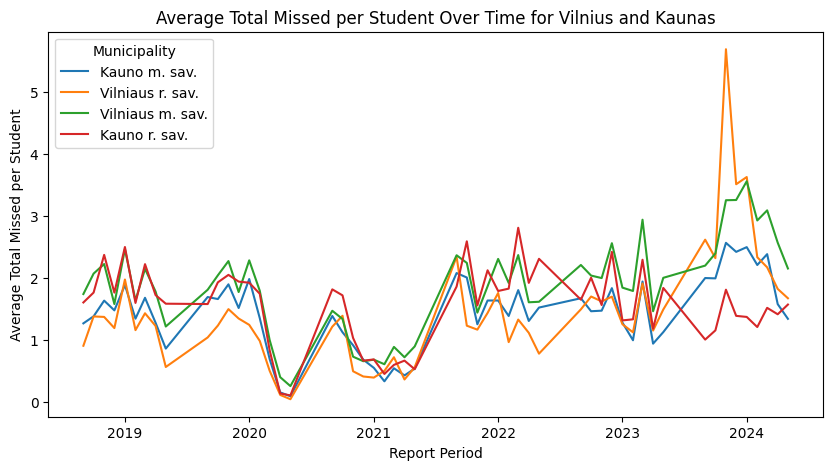

In [ ]:
# Answer
df_municipalities = df[df["municipality_name"].isin(municipalities)]

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_municipalities,
    x="report_period",
    y="total_missed_per_student",
    hue="municipality_name",
    errorbar=None
)
plt.title("Average Total Missed per Student Over Time for Vilnius and Kaunas")
plt.xlabel("Report Period")
plt.ylabel("Average Total Missed per Student")
plt.legend(title="Municipality")


### Task 3

There's something going on in the Vilnius region in school year 2023. Only for that municipality and school year, plot `total_missed_per_student` across time *by school*.

The plot should be titled and labelled clearly.


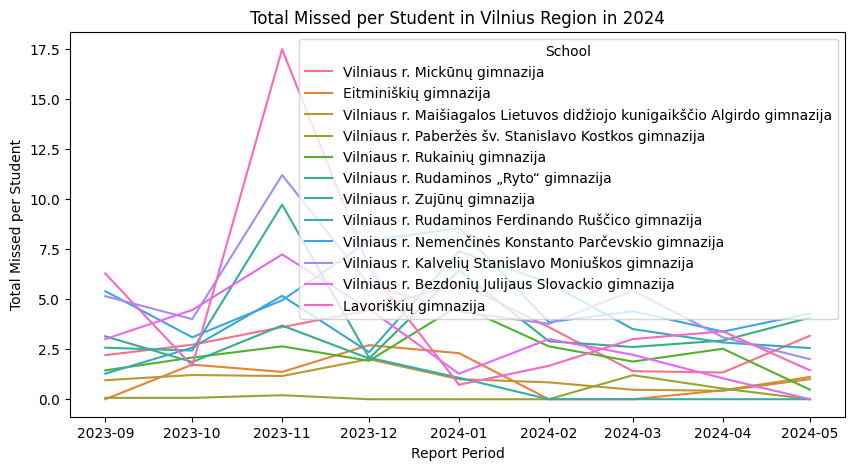

In [ ]:
# Answer
df_2023_vilnius_r = df[
    (df["school_year"] == 2023) & (df["municipality_name"] == "Vilniaus r. sav.")
]

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_2023_vilnius_r,
    x="report_period",
    y="total_missed_per_student",
    hue="school_name",
)
plt.title("Total Missed per Student in Vilnius Region in 2024")
plt.xlabel("Report Period")
plt.ylabel("Total Missed per Student")
plt.legend(title="School")

### Task 4

The plot above is not very nice to look at. Let's make it into a table.

Each row of the table should represent one school. Each column should be one report period. Only show data from 2023-09 to 2023-12. Apply conditional formatting on the *rows* of the table. The numbers in the table should be rounded to two significant digits.

Hint - you will have to pivot the table.


In [44]:
# Answer
df_2023_vilnius_r_9_12 = df_2023_vilnius_r[(df_2023_vilnius_r["month"].between(9, 12))]

pivoted = df_2023_vilnius_r_9_12.pivot(
    index="school_name", columns="report_period", values="total_missed_per_student"
)

pivoted.style.background_gradient(axis=1).format(precision=2)


report_period,2023-09-01,2023-10-01,2023-11-01,2023-12-01
school_name,,,,
Eitminiškių gimnazija,0.00,1.73,1.36,2.70
Lavoriškių gimnazija,6.28,1.67,17.47,6.56
Vilniaus r. Bezdonių Julijaus Slovackio gimnazija,3.00,4.45,7.23,4.50
Vilniaus r. Kalvelių Stanislavo Moniuškos gimnazija,5.14,4.00,11.19,5.71
Vilniaus r. Maišiagalos Lietuvos didžiojo kunigaikščio Algirdo gimnazija,0.95,1.21,1.16,2.00
Vilniaus r. Mickūnų gimnazija,2.20,2.72,3.60,4.44
Vilniaus r. Nemenčinės Konstanto Parčevskio gimnazija,5.39,3.09,4.94,7.91
Vilniaus r. Paberžės šv. Stanislavo Kostkos gimnazija,0.07,0.07,0.20,0.00
Vilniaus r. Rudaminos Ferdinando Ruščico gimnazija,1.27,2.58,5.16,2.35


### Task 5

What's causing a spike in total missed lessons on 2023-11 - unexcused missed lessons, illness, or "other"? Make a visualization that answers this question.


In [46]:
# Answer
df_2023_vilnius_r_11 = df_2023_vilnius_r[df_2023_vilnius_r["month"] == 11]

df_2023_vilnius_r_11[
    [
        "school_name",
        "excused_illness_per_student",
        "excused_other_per_student",
        "unexcused_per_student",
    ]
].style.background_gradient(axis=1).format(precision=2)

,school_name,excused_illness_per_student,excused_other_per_student,unexcused_per_student
428126,Vilniaus r. Kalvelių Stanislavo Moniuškos gimnazija,10.10,1.10,0.00
475171,Vilniaus r. Nemenčinės Konstanto Parčevskio gimnazija,2.58,2.36,0.00
1265811,Vilniaus r. Rudaminos „Ryto“ gimnazija,3.36,0.32,0.00
1355014,Vilniaus r. Maišiagalos Lietuvos didžiojo kunigaikščio Algirdo gimnazija,1.16,0.00,0.00
1393127,Vilniaus r. Zujūnų gimnazija,7.79,1.93,0.00
1766415,Eitminiškių gimnazija,1.36,0.00,0.00
2783684,Vilniaus r. Bezdonių Julijaus Slovackio gimnazija,7.23,0.00,0.00
2983201,Vilniaus r. Rukainių gimnazija,2.52,0.12,0.00
3065247,Vilniaus r. Rudaminos Ferdinando Ruščico gimnazija,4.00,1.16,0.00
3137002,Vilniaus r. Paberžės šv. Stanislavo Kostkos gimnazija,0.13,0.07,0.00


### Task 6

For the four municipalities mentioned above and for the report period of 2024-05-01, create a scatter plot with `excused_illness_per_student` on the y axis and `excused_other_per_student` on the x axis. Indicate which municipality the point on the plot belongs to.

The plot should be titled and labelled clearly.


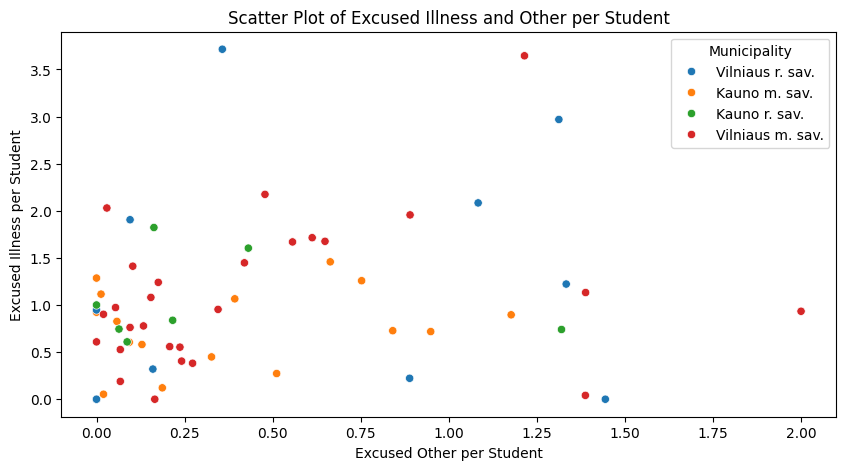

In [ ]:
# Answer
df_municipalities_2024_05 = df[
    (
        df["report_period"].astype(str) == "2024-05-01"
    )  # also ok: (df["school_year"] == 2023) & (df["month"] == 5)
    & df["municipality_name"].isin(municipalities)
]

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df_municipalities_2024_05,
    x="excused_other_per_student",
    y="excused_illness_per_student",
    hue="municipality_name",
)
plt.title("Scatter Plot of Excused Illness and Other per Student")
plt.xlabel("Excused Other per Student")
plt.ylabel("Excused Illness per Student")
plt.legend(title="Municipality")
plt.show()

### Task 7

Plot `total_missed_per_student` on a kdeplot for school year 2020, months September, February and May. Different months should have different curves.

The plot should be titled and labelled clearly.



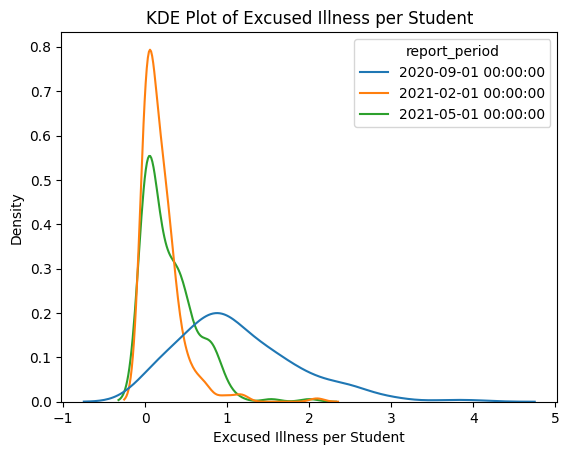

In [67]:
# Answer
df_2020 = df[(df["school_year"] == 2020) & (df["month"].isin([9, 2, 5]))]

sns.kdeplot(
    data=df_2020,
    x="excused_illness_per_student",
    hue="report_period",
)
plt.title("KDE Plot of Excused Illness per Student")
plt.xlabel("Excused Illness per Student")
plt.ylabel("Density")
plt.show()


### Task 8

So far we've been making single plots. How can we create multiple plots on a single canvas?

Plot the same plot as above, but for both `excused_other_per_student` and `excused_illness_per_student` on separate plots, but on the same canvas.

All plots should be titled and labelled clearly.


<Axes: xlabel='report_period', ylabel='excused_other_per_student'>

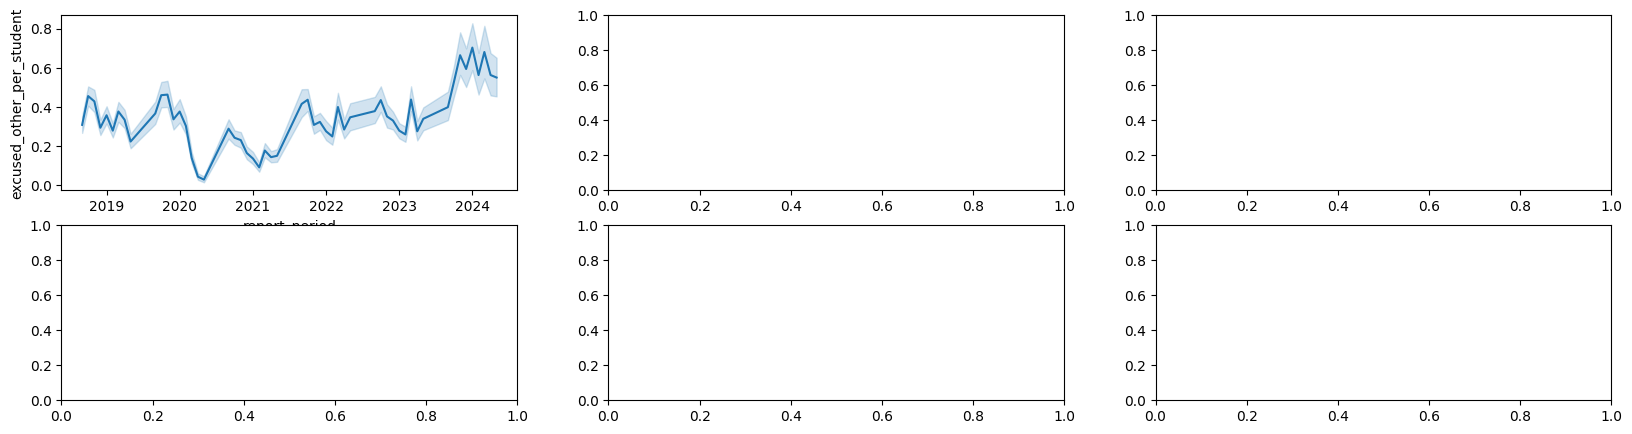

In [ ]:
# Hint
fig, axs = plt.subplots(2, 3, figsize=(20, 5))
sns.lineplot(data=df, x="report_period", y="excused_other_per_student", ax=axs[0][0])


Text(0.5, 0, '')

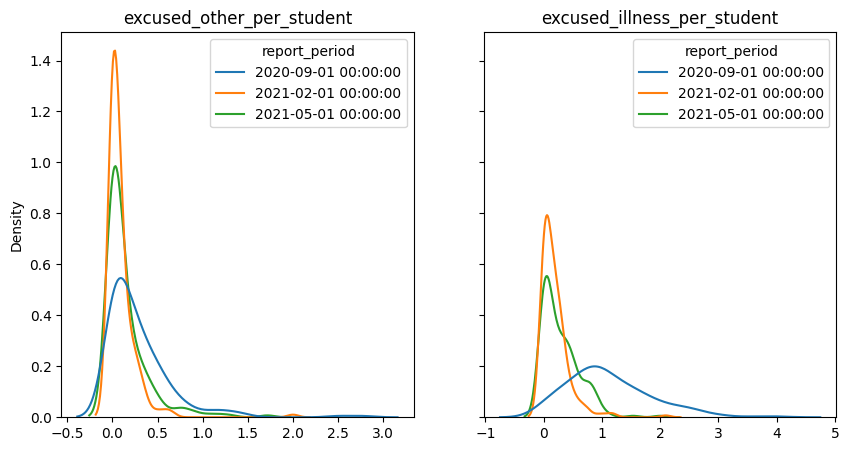

In [59]:
# Answer
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.kdeplot(data=df_2020, x="excused_other_per_student", ax=axs[0], hue="report_period")
axs[0].set_title("excused_other_per_student")
axs[0].set_xlabel(None)

sns.kdeplot(
    data=df_2020, x="excused_illness_per_student", ax=axs[1], hue="report_period"
)
axs[1].set_title("excused_illness_per_student")
axs[1].set_xlabel(None)

### Task 9

Now plot all three metrics on different plots, but still the same canvas. Don't repeat yourself! (use a for loop)

```

```

In [ ]:
# Hint
columns = [...]
fig, axs = plt.subplots(1, 3, figsize=(..., ...))
for column, ax in zip(columns, axs):
    pass

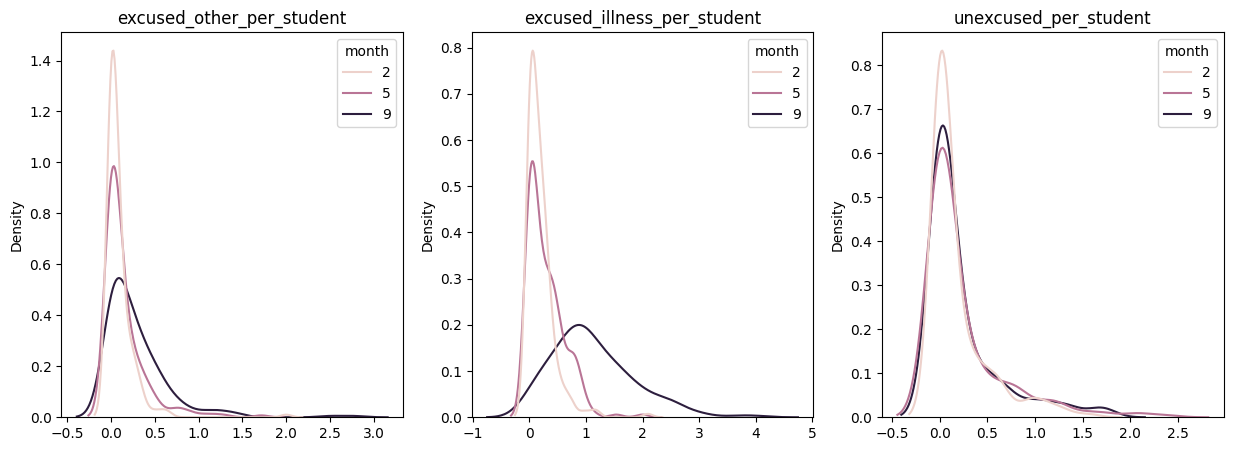

In [69]:
# Answer
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
columns = [
    "excused_other_per_student",
    "excused_illness_per_student",
    "unexcused_per_student",
]

for column, ax in zip(columns, axs):
    sns.kdeplot(data=df_2020, x=column, ax=ax, hue="month")
    ax.set_title(column)
    ax.set_xlabel(None)

### Task 10

One last table - show the number of schools, and then average, median and 90th percentile of `total_missed_per_student` by *municipality*, for the whole period (you don't need to apply any filters). 

Display top 20 schools by school count. Apply conditional formatting on the table such that outliers in each column stand out. Do not apply conditional formatting on the school count column.


In [ ]:
# hint - do this in the aggregation step
("total_missed_per_student", lambda x: x.quantile(0.8))


In [ ]:
# Step 1
# Aggregate by municipality
df_agg = df.groupby("municipality_name").agg(
    school_count=("school_name", "nunique"),
    mean_missed_per_student=("total_missed_per_student", "mean"),
    median_missed_per_student=("total_missed_per_student", "median"),
    perc_90_missed_per_student=("total_missed_per_student", lambda x: x.quantile(0.9)),
)
df_agg

,school_count,mean_missed_per_student,median_missed_per_student,perc_90_missed_per_student
municipality_name,,,,
Akmenės r. sav.,4,1.362629,1.267949,2.937976
Alytaus m. sav.,4,1.843795,1.947565,3.120192
Alytaus r. sav.,4,1.440894,1.204167,3.258242
Anykščių r. sav.,1,1.854703,1.913223,2.726483
Birštono sav.,1,1.991240,1.851326,3.199167
Biržų r. sav.,2,2.181808,2.254630,3.500488
Druskininkų sav.,1,1.769249,1.719161,2.511033
Elektrėnų sav.,3,1.632446,1.574501,3.034155
Ignalinos r. sav.,3,1.749105,1.710000,3.285950


In [ ]:
# Step 2
# Display the table
df_agg_sorted = df_agg.sort_values(by="school_count", ascending=False).head(20)

df_agg_sorted.style.background_gradient(
    subset=[
        "mean_missed_per_student",
        "median_missed_per_student",
        "perc_90_missed_per_student",
    ]
)

,school_count,mean_missed_per_student,median_missed_per_student,perc_90_missed_per_student
municipality_name,,,,
Vilniaus m. sav.,27,1.863925,1.744668,3.286349
Kauno m. sav.,16,1.423337,1.234432,2.743793
Klaipėdos m. sav.,13,1.501185,1.387793,2.833079
Vilniaus r. sav.,12,1.421369,1.084118,2.949573
Šalčininkų r. sav.,8,1.358287,1.000000,2.956618
Šiaulių m. sav.,7,1.557644,1.461211,2.853671
Kauno r. sav.,7,1.565639,1.496481,2.788515
Šilalės r. sav.,5,1.671297,1.763834,3.300000
Marijampolės sav.,5,1.798520,1.489295,3.933750
